# Harris Corner Detection

This document is based on

https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html

# Theory

Corners are regions in the image with large variation in intensity in all the directions. One early attempt to find these corners was done by **Chris Harris & Mike Stephens** in their paper, "**A Combined Corner and Edge Detector**" in 1988, so now it is called **Harris Corner Detector**. He took this simple idea to a mathematical form. It basically finds the difference in intensity for a displacement of (u, v) in all directions. This is expressed as below:

\begin{equation*}
E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2
\end{equation*}

Window function is either a rectangular window or gaussian window which gives weights to pixels underneath.

We have to maximize this function E(u,v) for corner detection. That means, we have to maximize the second term. Applying Taylor Expansion to above equation and using some mathematical steps (please refer any standard text books you like for full derivation), we get the final equation as:

\begin{equation*}
E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}
\end{equation*}

where

\begin{equation*}
M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}
\end{equation*}

Here, $I_x$ and $I_y$ are image derivatives in x and y directions respectively. (Can be easily found out using **cv2.Sobel()**).

Then comes the main part. After this, they created a score, basically an equation, which will determine if a window can contain a corner or not.

Then comes the main part. After this, they created a score, basically an equation, which will determine if a window can contain a corner or not.

\begin{equation*}
R = det(M) - k(trace(M))^2
\end{equation*}

**where**

* $\begin{equation*}det(M) = \lambda_1 \lambda_2\end{equation*}$
* $\begin{equation*}trace(M) = \lambda_1 + \lambda_2\end{equation*}$
* $\begin{equation*}\lambda_1 \; and \; \lambda_2 \;are \;the \;eigen \;values \;of \;M \end{equation*}$

So the values of these eigen values decide whether a region is corner, edge or flat.

* When |R| is small, which happens when \lambda_1 and \lambda_2 are small, the region is flat.
* When R<0, which happens when \lambda_1 >> \lambda_2 or vice versa, the region is edge.
* When R is large, which happens when \lambda_1 and \lambda_2 are large and \lambda_1 \sim \lambda_2, the region is a corner.

It can be represented in a nice picture as follows:

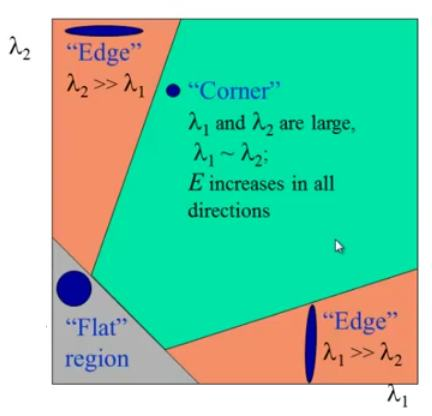

So the result of Harris Corner Detection is a grayscale image with these scores. Thresholding for a suitable give you the corners in the image. We will do it with a simple image.

In [ ]:
! git clone https://github.com/soonkijung/cv-datasets

fatal: destination path 'cv-datasets' already exists and is not an empty directory.


## Step 1:Convert the image to Grayscale

In [ ]:
from skimage import color
from skimage import io
from matplotlib import pyplot as plt
import scipy
import numpy as np

originalImg = color.rgb2gray(io.imread('/content/cv-datasets/blocks.gif'))

# three sample cases for easy understanding
sPtrs = [90, 15, 147, 110, 144, 198] # y1, x1, y2, x2, y3, x3
hSize = 5 # half Size
s1 = originalImg[sPtrs[0]-hSize:sPtrs[0]+hSize+1, sPtrs[1]-hSize:sPtrs[1]+hSize+1]
s2 = originalImg[sPtrs[2]-hSize:sPtrs[2]+hSize+1, sPtrs[3]-hSize:sPtrs[3]+hSize+1]
s3 = originalImg[sPtrs[4]-hSize:sPtrs[4]+hSize+1, sPtrs[5]-hSize:sPtrs[5]+hSize+1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  import sys


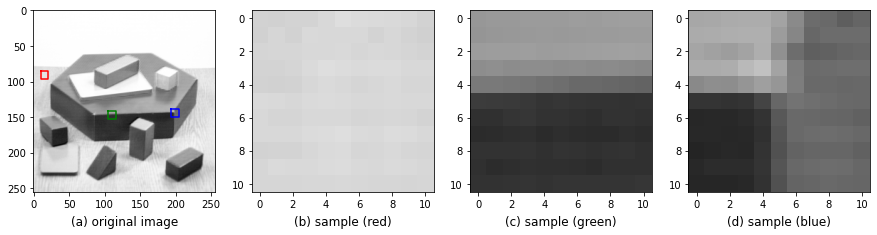

In [ ]:
def drawBox(ax, xp, yp, hs, color):
  ax.plot([xp-hs, xp+hs+1, xp+hs+1, xp-hs, xp-hs], [yp-hs, yp-hs, yp+hs+1, yp+hs+1, yp-hs], color=color)

fig, axs = plt.subplots(1, 4, figsize=(15, 6.5))
axs[0].imshow(originalImg, cmap='gray')
drawBox(axs[0], sPtrs[1], sPtrs[0], hSize, 'red')
drawBox(axs[0], sPtrs[3], sPtrs[2], hSize, 'green')
drawBox(axs[0], sPtrs[5], sPtrs[4], hSize, 'blue')
axs[0].text(0.5, -0.18, '(a) original image', size=12, ha='center', transform=axs[0].transAxes)
axs[1].imshow(s1, vmin=0, vmax=255, cmap='gray')
axs[1].text(0.5, -0.18, '(b) sample (red)', size=12, ha='center', transform=axs[1].transAxes)
axs[2].imshow(s2, vmin=0, vmax=255, cmap='gray')
axs[2].text(0.5, -0.18, '(c) sample (green)', size=12, ha='center', transform=axs[2].transAxes)
axs[3].imshow(s3, vmin=0, vmax=255, cmap='gray')
axs[3].text(0.5, -0.18, '(d) sample (blue)', size=12, ha='center', transform=axs[3].transAxes)
plt.show()

In [ ]:
def calcEuv(image, x, y, hSize, offset):
  s = image[y-hSize:y+hSize+1, x-hSize:x+hSize+1]
  Euv = np.zeros((2*offset+1, 2*offset+1))
  for u in range(-offset, offset+1):
    for v in range(-offset, offset+1):
      shifted = image[y+u-hSize:y+u+hSize+1, x+v-hSize:x+v+hSize+1]
      Euv[u+offset, v+offset] = ((shifted - s)**2).sum()
  return Euv

print("Define calcEuv")

window_size = 5
offset = window_size // 2
Euv1 = calcEuv(originalImg, sPtrs[1], sPtrs[0], hSize, offset)
Euv2 = calcEuv(originalImg, sPtrs[3], sPtrs[2], hSize, offset)
Euv3 = calcEuv(originalImg, sPtrs[5], sPtrs[4], hSize, offset)


Define calcEuv


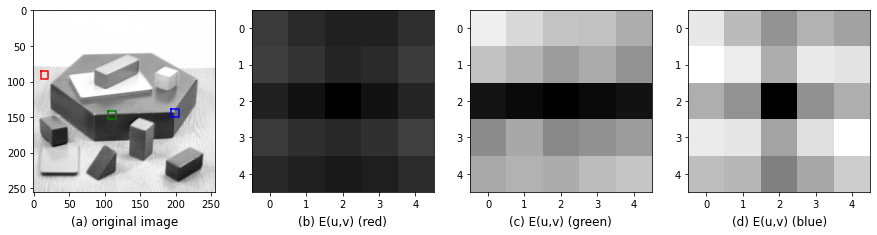

In [ ]:
maxV = max([np.max(Euv1), np.max(Euv2), np.max(Euv3)])
fig, axs = plt.subplots(1, 4, figsize=(15, 6.5))
axs[0].imshow(originalImg, cmap='gray')
drawBox(axs[0], sPtrs[1], sPtrs[0], hSize, 'red')
drawBox(axs[0], sPtrs[3], sPtrs[2], hSize, 'green')
drawBox(axs[0], sPtrs[5], sPtrs[4], hSize, 'blue')
axs[0].text(0.5, -0.18, '(a) original image', size=12, ha='center', transform=axs[0].transAxes)
axs[1].imshow(Euv1, vmax = maxV, cmap='gray')
axs[1].text(0.5, -0.18, '(b) E(u,v) (red)', size=12, ha='center', transform=axs[1].transAxes)
axs[2].imshow(Euv2, vmax = maxV, cmap='gray')
axs[2].text(0.5, -0.18, '(c) E(u,v) (green)', size=12, ha='center', transform=axs[2].transAxes)
axs[3].imshow(Euv3, vmax = maxV, cmap='gray')
axs[3].text(0.5, -0.18, '(d) E(u,v) (blue)', size=12, ha='center', transform=axs[3].transAxes)
plt.show()

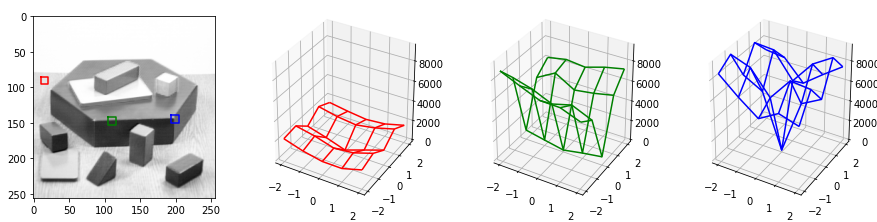

In [ ]:
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(15, 3.7))

X = np.arange(-offset, offset+1)
Y = np.arange(-offset, offset+1)
X, Y = np.meshgrid(X, Y)
Z1 = Euv1[Y+offset, X+offset]
Z2 = Euv2[Y+offset, X+offset]
Z3 = Euv3[Y+offset, X+offset]

ax0 = fig.add_subplot(141)
ax0.imshow(originalImg, cmap='gray')

drawBox(ax0, sPtrs[1], sPtrs[0], hSize, 'red')
drawBox(ax0, sPtrs[3], sPtrs[2], hSize, 'green')
drawBox(ax0, sPtrs[5], sPtrs[4], hSize, 'blue')

ax1 = fig.add_subplot(142, projection='3d')
ax1.plot_wireframe(X, Y, Z1, color='red')

ax2 = fig.add_subplot(143, projection='3d', sharez=ax1)
ax2.plot_wireframe(X, Y, Z2, color='green')

ax3 = fig.add_subplot(144, projection='3d', sharez=ax1)
ax3.plot_wireframe(X, Y, Z3, color='blue')

plt.show()

## Step 2:Spatial derivative calculation
We use the Sobel filter to obtain the derivatives

In [ ]:
from scipy import signal

def gradient_x(imggray):
  # Sobel operator kernels.
  kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  return signal.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
  # Sobel operator kernels.
  kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  return signal.convolve2d(imggray, kernel_y, mode='same')

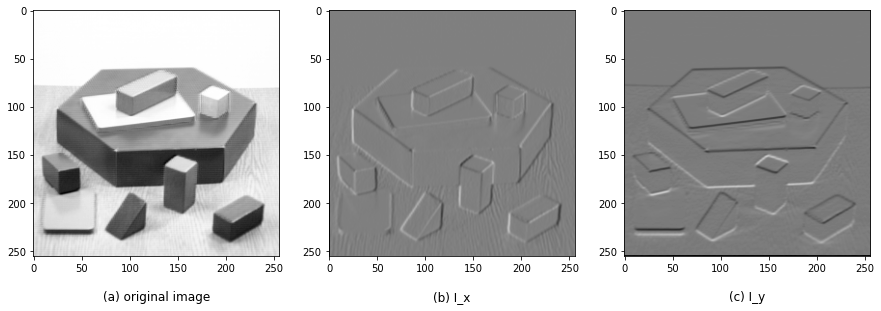

In [ ]:
I_x = gradient_x(originalImg)
I_y = gradient_y(originalImg)

fig, axs = plt.subplots(1, 3, figsize=(15, 6.5))
axs[0].imshow(originalImg, cmap='gray')
axs[0].text(0.5, -0.18, '(a) original image', size=12, ha='center', transform=axs[0].transAxes)
axs[1].imshow(I_x, cmap='gray')
axs[1].text(0.5, -0.18, '(b) I_x', size=12, ha='center', transform=axs[1].transAxes)
axs[2].imshow(I_y, cmap='gray')
axs[2].text(0.5, -0.18, '(c) I_y', size=12, ha='center', transform=axs[2].transAxes)
plt.show()

## Step 3:The Second-Order Derivatives of Image

In [ ]:
def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g = np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g

print("Define gaussian_kernel")

gKernel = gaussian_kernel(5, 1.4)

Define gaussian_kernel


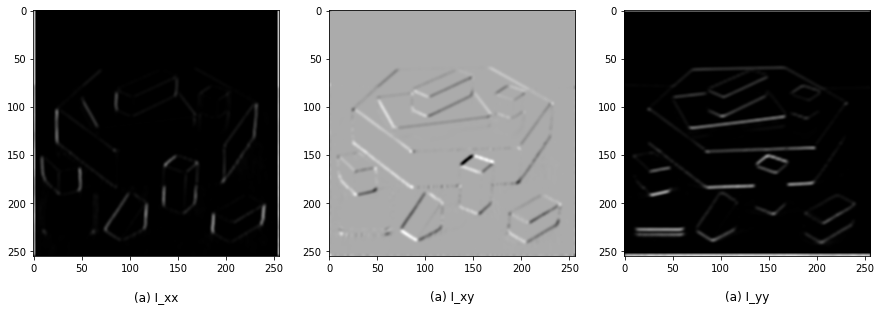

In [ ]:
gI_xx = signal.convolve2d(I_x**2, gKernel, mode='same')
gI_xy = signal.convolve2d(I_x*I_y, gKernel, mode='same')
gI_yy = signal.convolve2d(I_y**2, gKernel, mode='same')

fig, axs = plt.subplots(1, 3, figsize=(15, 6.5))
axs[0].imshow(gI_xx, cmap='gray')
axs[0].text(0.5, -0.18, '(a) I_xx', size=12, ha='center', transform=axs[0].transAxes)
axs[1].imshow(gI_xy, cmap='gray')
axs[1].text(0.5, -0.18, '(a) I_xy', size=12, ha='center', transform=axs[1].transAxes)
axs[2].imshow(gI_yy, cmap='gray')
axs[2].text(0.5, -0.18, '(a) I_yy', size=12, ha='center', transform=axs[2].transAxes)
plt.show()

## Step 4:Harris response calculation
We first calculate the sum of squares of our gradient at each pixel by shifting a window over all the pixels in the image. The window is shifted according to the offset which you decided based on your image. THe window function $w(x,y)$ is 1 in the window, and 0 out of the window. In this experiment, the window size is 5.

$α$ is the sensitivity factor to separate corners from edges, typically (0.04 to 0.06), for this experiment I have taken $α = 0.04$. Small values of $α$ result in detection of sharp corners.

The cornerness, $C = λ_1λ_2 - α(λ_1+λ_2)^2$ and calculated by $C = det(M) - $$α$ $trace(M)^2$

In [ ]:
image_copy = color.gray2rgb(originalImg)
height = originalImg.shape[0]
width = originalImg.shape[1]
alpha = 0.04

corner = np.zeros((height, width), np.float32)
for y in range(window_size, height-window_size):
  for x in range(window_size, width-window_size):
    Sxx = np.sum(gI_xx[y-offset:y+offset+1, x-offset:x+offset+1])
    Sxy = np.sum(gI_xy[y-offset:y+offset+1, x-offset:x+offset+1])
    Syy = np.sum(gI_yy[y-offset:y+offset+1, x-offset:x+offset+1])

    # Find determinant and trace, use to get the cornerness
    det = Sxx * Syy - Sxy**2
    trace = Sxx + Syy
    corner[y, x] = det - alpha*trace**2

In [ ]:
def non_maxima_suppression(response, thresh):
  h, w = response.shape
  result = np.zeros((h, w))
  for y in range(h-1):
    for x in range(w-1):
      if response[y, x] > thresh and\
        response[y, x] > response[y-1, x-1] and\
        response[y, x] > response[y-1, x] and\
        response[y, x] > response[y-1, x+1] and\
        response[y, x] > response[y, x-1] and\
        response[y, x] > response[y, x+1] and\
        response[y, x] > response[y+1, x-1] and\
        response[y, x] > response[y+1, x] and\
        response[y, x] > response[y+1, x+1]:
        result[y, x] = 1
        for d in range(-3, 4):
          result[y+d, x] = result[y, x+d] = 1
  return result

print("Define non maxima supression")

Define non maxima supression


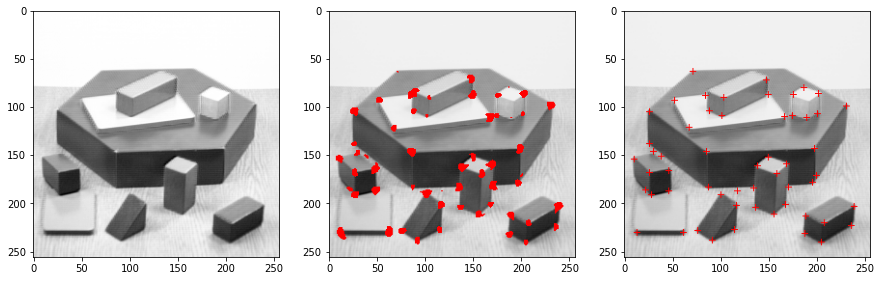

In [ ]:
thresh = 0.01*corner.max()
image_copy[corner > thresh] = [255, 0, 0]

result = non_maxima_suppression(corner, thresh)
image_copy2 = color.gray2rgb(originalImg)
image_copy2[result == 1] = [255, 0, 0]

fig, axs = plt.subplots(1, 3, figsize=(15, 6.5))
axs[0].imshow(originalImg, cmap='gray')
axs[1].imshow(image_copy)
axs[2].imshow(image_copy2)
plt.show()

# cv2.cornerHarris

Use the Harris corner detector in OpenCV library.

`cv2.cornerHarris(src, blockSize, ksize, k[, dst[, borderType]]) : dst`

Parameters:
* `src` - Input single-channel 8-bit or floating-point image.
* `dst` - Image to store the Harris detector responses. It has the type `cv_32FC1` and the same size as `src`.
* `blockSize`- Neighborhood size
* `ksize` - Aperture parameter for the `Sobel()` operator.
* `k` - Harris detector free parameter. $α$
* `borderType` - Pixel extrapolation method.

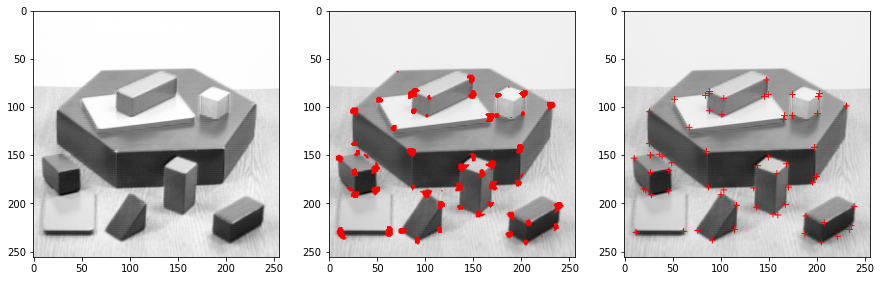

In [ ]:
import cv2

dest = cv2.cornerHarris(originalImg, window_size, 3, 0.04)

image_copy - color.gray2rgb(originalImg)
thresh = 0.01 * dest.max()
image_copy[dest > thresh] = [255, 0, 0]

result = non_maxima_suppression(dest, thresh)
image_copy2 = color.gray2rgb(originalImg)
image_copy2[result == 1] = [255, 0, 0]

fig, axs = plt.subplots(1, 3, figsize=(15, 6.5))
axs[0].imshow(originalImg, cmap='gray')
axs[1].imshow(image_copy)
axs[2].imshow(image_copy2)
plt.show()